In [2]:
import numpy as np


In [3]:
###############第一节课：搭建网络框架、初始化网络参数##########################
dimensions=[28*28, 10]    #第一个参数是图片的维度，第二个参数是output的维度

In [4]:
#定义激活函数
def tanh(x):
    x=np.array(x)
    return np.tanh(x)

    
def softmax(x):
    x=np.array(x)
    exp = np.exp(x-x.max())   # x-x.max()的作用是防止指数爆炸，在经过相减运算后，不影响最后的结果
    return exp/exp.sum()      #因为在代码中使用了x.max()，而普通数组是没有这样的max函数的，而np.array()有
                              #所以在传参进softmax(x)时，要传进来np.array(x)

                             

In [109]:
#定义初始化参数的函数
def init_parematers(input_dim, output_dim):  #参数为输入图片的维度和输出图片的维度
    b0 = np.zeros(input_dim)   #b0为全零，大小为784*1
    b1 = np.zeros(output_dim)  #b1为全零，大小为10*1
    w1 = np.random.rand(input_dim, output_dim)  #w1为随机，大小为784*10
    
    init_parameters_b_w = [   #以字典的形式返回所有参数
        {'b0':b0},
        {'b1':b1, 'w1':w1}
    ]
    return init_parameters_b_w


In [6]:
##########################第二节课：读取并显示MNIST中的数据##################################
#设置训练集，验证集和测试集
train_set_num = 50000
valid_set_num = 10000
test_set_num = 10000

In [7]:
#读取MNIST文件
import os

root_path = os.path.abspath('.')  #获取当前文件夹的绝对路径

train_img_path = os.path.join(root_path,"MNIST\\train-images.idx3-ubyte") #join()函数能将两个参数地址拼接到一起
train_lab_path = os.path.join(root_path,"MNIST\\train-labels.idx1-ubyte")

test_img_path = os.path.join(root_path,"MNIST\\t10k-images.idx3-ubyte")
test_lab_path = os.path.join(root_path,"MNIST\\t10k-labels.idx1-ubyte")

# 读取训练集中的图片数据
with open(train_img_path, 'rb') as t:  
    t.seek(16)    #因为train-images.idx3-ubyte中，前16个字节的数据是描述这个文件的，所以真正的数据是从16后面开始的
    train_img = np.fromfile(t,dtype=np.uint8).reshape(-1,28*28)  #np.fromfile()作用：从文本或二进制文件中的数据构造一个数组
    #reshape(-1,28*28)的解释：-1代表自动检测，因为不知道源文件中有多少个手写体数字，但是知道每个图片都是28*28的，所以第一个参数为-1就代表自动检测文件中有多少个28*28的图片
    train_img = train_img[:train_set_num]   #从60000训练集中分离出前50000个为真正的训练集
    valid_img = train_img[valid_set_num:]   #从60000训练集中分离出后10000个为验证集

# 读取训练集中的标签数据
with open(train_lab_path, 'rb') as t:  
    t.seek(8)    #在train-labels.idx1-ubyte中，前8个字节的数据是描述这个文件的
    train_lab = np.fromfile(t,dtype=np.uint8)
    train_lab = train_lab[:train_set_num]   
    valid_lab = train_lab[valid_set_num:]

# 读取测试集中的图片数据
with open(test_img_path, 'rb') as t:  
    t.seek(16) 
    test_img = np.fromfile(t,dtype=np.uint8).reshape(-1,28*28)


# 读取测试集中的标签数据
with open(test_lab_path, 'rb') as t:  
    t.seek(8)    
    test_lab = np.fromfile(t,dtype=np.uint8)
    

In [8]:
#把数据画出来
import matplotlib.pyplot as plt

#画出训练集数据
def show_train_img(index):
    img = train_img[index].reshape(28,28)  #前面读取图片时的28*28是告诉程序每一张图片有多大，最后仍然是按行来储存读出来的数据（即:1*784的一维数据），而此处的28*28则是将读出来的那个一维数据转换成二维交给画图程序画图
    plt.imshow(img, cmap="gray")     #用灰度的格式将图片画出来
    print("train_data:{}".format(train_lab[index]))     #打印图片对应的标签

#画出验证集数据
def show_valid_img(index):
    img = valid_img[index].reshape(28,28)
    plt.imshow(img,cmap="gray")
    print("valid_data:{}".format(valid_lab[index]))

#画出测试集数据
def show_test_img(index):
    img = test_img[index].reshape(28,28)
    plt.imshow(img,cmap="gray")
    print("test_data:{}".format(test_lab[index]))

train_data:6


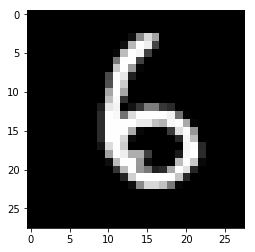

In [9]:
#显示训练集图片和标签
show_train_img(np.random.randint(50000))

valid_data:0


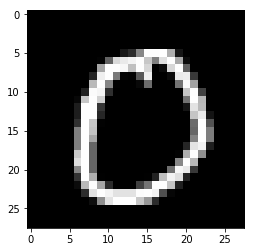

In [10]:
#显示验证集的图片和标签
show_valid_img(np.random.randint(10000))

test_data:9


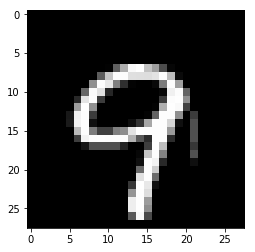

In [11]:
#显示测试集图片和标签
show_test_img(np.random.randint(10000))

In [12]:
################第四节课：反向传播和梯度下降更新网络中的参数#################################
# 计算梯度下降所用到的导数
# 注意！！！(传参时，参数中所有的x必须是np的数组对象)
def d_tanh(x):   
    return np.diag(1/(np.cosh(x))**2)

def d_softmax(x):
    sm=softmax(x)
    return np.diag(sm)-np.outer(sm,sm)


In [13]:
#计算y_real和y_predict的差值
def diff_yreal_ypredict(img_lab,img_data,b0,b1,w1):

    l0_in=img_data+b0  #l0=tanh(data+b0)
    l0_out=tanh(l0_in)

    l1_in=np.dot(l0_out,w1)+b1
    l1_out=softmax(l1_in)

    y_predict=l1_out #用y_predict来代表预测值

    y_real=[0 for i in range(10)]  #y_real为长度为10的数组
    y_real=np.eye(10)              #生成10*10的对角矩阵
    y_real=y_real.reshape(-1,1*10)  #用y_real来代表真实世界的值，y_real[0]就代表[1 0 0 0 0 0 0 0 0]，即label=1的数字的理想输出, y_real[1]同理
    
    return y_real[img_lab]-y_predict  #返回差值

In [14]:
#计算梯度下降的函数

#求L对b1的偏导数=-2 * (y-output) * d_A2
def L_to_b1(img_lab,img_data,b0,b1,w1):
    l0_in=img_data+b0  #l0=tanh(data+b0)
    l0_out=tanh(l0_in)
    
    l1_in=np.dot(l0_out,w1)+b1

    d_A2=d_softmax(l1_in)  #求softmax的偏导

    diff=diff_yreal_ypredict(img_lab,img_data,b0,b1,w1)  #求y-output的差值

    result=np.dot(d_A2,diff)    #计算L对b1的偏导数的结果
    
    return result

#求L对w1的偏导数=-2 * (y-output) * d_A2 * l0
def L_to_w1(img_lab,img_data,b0,b1,w1):

    l0_in=img_data+b0  #l0=tanh(data+b0)
    l0_out=tanh(l0_in)
    
    l1_in=np.dot(l0_out,w1)+b1

    d_A2=d_softmax(l1_in)  #求softmax的偏导

    diff=diff_yreal_ypredict(img_lab,img_data,b0,b1,w1)  #求y-output的差值

    mid_temp=np.dot(d_A2,diff)    #计算L对b1的偏导数的结果

    l0_out=l0_out.reshape(784,1)
    mid_temp=mid_temp.reshape(1,10)

    result=np.dot(l0_out,mid_temp)
    
    return result


#求L对b1的偏导数=-2 * (y-output) * d_A2 * w1 * d_A1  (d_A2代表队A2求导，A2是第二层的激活函数“softmax”，A1是第一层的激活函数“tanh”)
def L_to_b0(img_lab,img_data,b0,b1,w1):

    l0_in=img_data+b0  #l0=tanh(data+b0)
    l0_out=tanh(l0_in)
    
    l1_in=np.dot(l0_out,w1)+b1  #l1=softmax(w1*l0+b1)   (注意！)内积运算中，l0和w1的位置不能颠倒

    d_A1=d_tanh(l0_in)  #求tanh的偏导
    d_A2=d_softmax(l1_in)  #求softmax的偏导

    diff=diff_yreal_ypredict(img_lab,img_data,b0,b1,w1)  #求：y-output

    mid_temp_1=np.dot(d_A2,diff)   #求：(y-output)*d_A2

    mid_temp_2=np.dot(w1,mid_temp_1)   #求：w1*(y-output)*d_A2

    result = np.dot(d_A1,mid_temp_2)#   #求：w1*(y-output)*d_A2*d_A1

    return result


In [ ]:
# 测试模型精确度(使用验证集里面的数据)
def valid_accuracy(b0,b1,w1):
    valid_epoch=1000 # 测试的次数
    correct_num=0;  #测试结果为正确的个数
    for i in range(valid_epoch):
        img_num=np.random.randint(10000)
        img_data=valid_img[img_num]
        img_lab=valid_lab[img_num]

        l0_in=img_data+b0  #l0=tanh(data+b0)
        l0_out=tanh(l0_in)
        l1_in=np.dot(l0_out,w1)+b1
        l1_out=softmax(l1_in)

        if l1_out.argmax() == img_lab:   #如果predict结果与标签一致，则验证正确
            correct_num+=1

    return correct_num/valid_epoch


In [ ]:
# 测试模型精确度(使用训练集里面的数据)
def train_accuracy(b0,b1,w1):
    valid_epoch=1000 # 测试的次数
    correct_num=0;  #测试结果为正确的个数
    for i in range(valid_epoch):
        img_num=np.random.randint(10000)
        img_data=train_img[img_num]
        img_lab=train_lab[img_num]

        l0_in=img_data+b0  #l0=tanh(data+b0)
        l0_out=tanh(l0_in)
        l1_in=np.dot(l0_out,w1)+b1
        l1_out=softmax(l1_in)

        if l1_out.argmax() == img_lab:   #如果predict结果与标签一致，则验证正确
            correct_num+=1

    return correct_num/valid_epoch

In [ ]:
# 测试模型精确度(使用测试集里面的数据)
def train_accuracy(b0,b1,w1):
    valid_epoch=1000 # 测试的次数
    correct_num=0;  #测试结果为正确的个数
    for i in range(valid_epoch):
        img_num=np.random.randint(10000)
        img_data=test_img[img_num]
        img_lab=test_lab[img_num]

        l0_in=img_data+b0  #l0=tanh(data+b0)
        l0_out=tanh(l0_in)
        l1_in=np.dot(l0_out,w1)+b1
        l1_out=softmax(l1_in)

        if l1_out.argmax() == img_lab:   #如果predict结果与标签一致，则验证正确
            correct_num+=1

    return correct_num/valid_epoch

In [271]:
#################训练开始#################

#初始化参数
b0=init_parematers(784, 10)[0]['b0']

w1=init_parematers(784, 10)[1]['w1']

b1=init_parematers(784, 10)[1]['b1']

y=np.eye(10)

In [335]:
#训练网络
batch_size=100   #100张图片为一组

total_batch=train_set_num // batch_size   #总共有500个组

learning_rate=0.2   #学习率（经过多次实验，0.2的学习率和500的代数效果好一点，正确率能达到85%）
sample_epoch=500     #每个样本的梯度更新次数
sample_num=1000     #要喂进网络中的样本的个数

y=np.eye(10)        #onehot类型的标签值


#训练网络
for sample_index in range(sample_num):
    current_img=np.random.randint(50000)     # 从训练集中随机选取样本进行训练
    img_data=train_img[current_img]      # 获取样本的数据
    img_lab=train_lab[current_img]       #获取样本的标签

    #搭建网络（2层）
    l0_in=(img_data+b0)/255  #l0=tanh(data+b0)    因为使用的时tanh函数，而数据中有最大值255，为了避免tanh的死区，进行归一化处理，让每个值都在（-1，1）中间
    l0_out=tanh(l0_in)
    l1_in=np.dot(l0_out,w1)+b1
    l1_out=softmax(l1_in)

    #网络的输出结果
    y_predict=l1_out

    #计算loss值
    diff=y[img_lab]-y_predict
    loss=((diff**2).sum())

    #打印未经过训练的网络的loss值
    print("-第{}次的第{}张图片 随机loss:{}".format(sample_index,current_img,loss))

    # 对每个样本更新参数
    for epoch_index in range(sample_epoch):
        if loss<1e-03 :    #如果精度达到0.001的话就算满足要求了（节省训练时间）
            break

        # 计算参数的梯度值
        d_b1=L_to_b1(img_lab,img_data,b0,b1,w1)
        d_w1=L_to_w1(img_lab,img_data,b0,b1,w1)
        d_b0=L_to_b0(img_lab,img_data,b0,b1,w1)

        # 更新参数
        b1=b1+d_b1*learning_rate
        w1=w1+d_w1*learning_rate
        b0=b0+d_b0*learning_rate


        l0_in=img_data+b0  #l0=tanh(data+b0)
        l0_out=tanh(l0_in)
        l1_in=np.dot(l0_out,w1)+b1
        l1_out=softmax(l1_in)

        y_predict=l1_out

        # 获取训练过后的loss值
        diff=y[img_lab]-y_predict
        loss=((diff**2).sum())

        print("--第{}次的第{}张图片的第{}代 训练loss:{}".format(sample_index,current_img,epoch_index,loss))    





-第0次的第44385张图片 随机loss:1.637449363656819
--第0次的第44385张图片的第0代 训练loss:1.99309289614557
--第0次的第44385张图片的第1代 训练loss:1.9915486743147675
--第0次的第44385张图片的第2代 训练loss:1.9891644053044868
--第0次的第44385张图片的第3代 训练loss:1.9850594844544152
--第0次的第44385张图片的第4代 训练loss:1.9766269176784477
--第0次的第44385张图片的第5代 训练loss:1.9525310973243923
--第0次的第44385张图片的第6代 训练loss:1.8007415271643286
--第0次的第44385张图片的第7代 训练loss:0.0029918574451868267
--第0次的第44385张图片的第8代 训练loss:0.002126350306420991
--第0次的第44385张图片的第9代 训练loss:0.0016666295138742693
--第0次的第44385张图片的第10代 训练loss:0.0013765063909645671
--第0次的第44385张图片的第11代 训练loss:0.0011752262455059928
--第0次的第44385张图片的第12代 训练loss:0.0010267932169283607
--第0次的第44385张图片的第13代 训练loss:0.0009125253534991854
-第1次的第5346张图片 随机loss:1.3288026868597212e-06
-第2次的第48605张图片 随机loss:0.0001608833695206142
-第3次的第3612张图片 随机loss:0.00026716886900699714
-第4次的第27473张图片 随机loss:0.3619997480720021
--第4次的第27473张图片的第0代 训练loss:3.1669036961617e-08
-第5次的第22983张图片 随机loss:0.3196999630859898
--第5次的第22983张图片的第0代 训练loss:6.6763

In [353]:
# 把模型应用到测试集当中，验证正确率
correct_rate=valid_accuracy(b0,b1,w1)
print("测试集的确率为: ",correct_rate)

测试集的确率为:  0.828


In [352]:
# 把模型应用到训练集当中，验证正确率
correct_rate=train_accuracy(b0,b1,w1)
print("训练集的正确率为: ",correct_rate)

训练集的正确率为:  0.861
